# __ASE ANI implementation__
This notebook contains the installation procedure and initial testing provided in the TorchANI [GitHub](https://github.com/aiqm/torchani) and the [documentation](https://aiqm.github.io/torchani/).

Similarly to MACE, this implementation in python allows us to use the architecture to train or fine-tune new models with other training data, but also include a set of pretrained models, ready to use. An ASE calculator is provided and a great deal of examples are listed in the documentation, which makes it a well documented repo. 

### __Installation procedure__
Refer to ASE installation for the basics of the miniconda `venv` where MACE will be installed. This ensures that other calculators will not break the environment.
- ASE installation process
    - Create new conda environment (python 3.10 is standard). Check the Python requirement for the external calculator wanted. Usually  `python>3.9`.  
    - `conda install ase` (installs `scipy` and `numpy` dependencies) and `conda install matplotlib`. 
    - Check the environment works installing `conda install pytest` and `ase test`.
    - For ASE representations inside Jupyter Notebook, conda install `notebook`, `ipywidgets` and `nglview`. 
- TorchANI installation process
    - Clone base ASE environment. 
    - `conda install torchani` via the preconfigured `conda-forge` channel. Check the conda installation for further notes. 
    - With `pytest` installed (ASE base installation), the `test` directory from the repo is downloaded as well as the `download.sh` script.
    - `./download.sh` to run the script (use `chmod 777 download.sh` to modify the permissions). This will download all the weights of the ANI model. 
    - Before running the tests, install `expecttest pkbar tqdm`, `pip install tb-nightly` (check the test requirements at `test_requirements.txt`). Additional packages installed are inluced in `docs_requirements.txt`, `h5py tb-nightly sphinx sphinx_rtd_theme matplotlib pillow sphinx-gallery`. Note that `tb-nightly sphinx_rtd_theme sphinx-gallery` must be installed via `pip`. 
    - **Important.** Replace the `tests/test_data` directory with the `download/test_data` directory generated when running `download.sh`. 
    - run the tests in the `test` directory. `python <test>.py`. 

**Important.** The tests and examples provided only work if the repo is donwloaded and the tests/examples are located in a specific path (inside `site-packages/torchani/`). 

**Obs.** An additional error coming from `ASE` has been observed regarding the `ase/calculators/fd.py` `calculate_numerical_forced`. 

### __References__
[TUTORIALS] 

ASE interface can be found here https://aiqm.github.io/torchani/api.html#module-torchani.ase. 

## __TorchANI pretrained models__
TorchANI is similar to MACE in the sense that it provides a way to train and evaluate models, but it also contains pretrained models ready to use, which use an ASE interface with defined calculators. The models are included in `models.py`. The calculator creation is different from `MACECalculator` or `ORBCalculator`, as it is created using a method `.ase()` applied to a model object. The available models are the following
- `ANI1x`
    - Ensemble of 8 networks that was trained using active learning on the ANI-1x dataset, the target level of theory is wB97X/6-31G(d). It predicts energies on HCNO elements exclusively. Neutral molecules only. 

- `ANI1ccx`
    - Ensemble of 8 networks that was trained on the ANI-1ccx dataset, using transfer learning. The target accuracy is CCSD(T)*/CBS (CCSD(T) using the DPLNO-CCSD(T) method). It predicts energies on HCNO elements exclusively. Neutral molecules only. 

- `ANI2x`
    - Ensemble of 8 networks that was trained on the ANI-2x dataset. The target level of theory is wB97X/6-31G(d). It predicts energies on HCNOFSCl elements exclusively. 

- `.ase()`
    Generates an `ase.Calculator` object from the ANI model object. 

In [3]:
# ase imports

# import the calculators
from torch import device
from torchani.models import ANI1x, ANI2x, ANI1ccx


#=======================#
#       CALCULATORS     #   
#=======================#

ani1x_calc = ANI1x().ase()
ani1ccx_calc = ANI1ccx().ase()
ani2x_calc = ANI2x().ase()

# device type can defined via torch and parsed to the model via .to() method
device_ = device('cpu')
model_ = ANI1x(periodic_table_index=True).to(device_).double().ase()

/Users/sergiortizropero/miniconda3/envs/ASE_ANI/lib/python3.10/site-packages/torchani/resources/
/Users/sergiortizropero/miniconda3/envs/ASE_ANI/lib/python3.10/site-packages/torchani/resources/
/Users/sergiortizropero/miniconda3/envs/ASE_ANI/lib/python3.10/site-packages/torchani/resources/
/Users/sergiortizropero/miniconda3/envs/ASE_ANI/lib/python3.10/site-packages/torchani/resources/


## __1. ASE TorchANI calculator usage__

In [2]:
# ase 
from ase import build

# torchani
from torchani.models import ANI1x, ANI1ccx

# define calculators
ani1x_calc = ANI1x().ase()
ani1ccx_calc = ANI1ccx().ase()

atoms = build.molecule('H2O')

atoms.calc = ani1x_calc
x_H2O_energy = atoms.get_potential_energy()
print(f'H2O energy @ ANI-1x:\t{x_H2O_energy}')

atoms.calc = ani1ccx_calc
cc_H2O_energy = atoms.get_potential_energy()
print(f'H2O energy @ ANI-1ccx:\t{cc_H2O_energy}')

/Users/sergiortizropero/miniconda3/envs/ASE_ANI/lib/python3.10/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")


/Users/sergiortizropero/miniconda3/envs/ASE_ANI/lib/python3.10/site-packages/torchani/resources/
/Users/sergiortizropero/miniconda3/envs/ASE_ANI/lib/python3.10/site-packages/torchani/resources/
H2O energy @ ANI-1x:	-2078.6371570369956
H2O energy @ ANI-1ccx:	-2078.4991794369125


In [3]:
# check the energy of formation of the H2O molecule
calc_list = [ani1x_calc, ani1ccx_calc]
atomic_energies = []

k = 0
for calc_ in calc_list:
    # define the atoms
    atom_O = build.molecule('O')
    atom_H = build.molecule('H')

    atom_O.calc = calc_
    atom_H.calc = calc_

    energy_H = atom_H.get_potential_energy()
    energy_O = atom_O.get_potential_energy()
    atomic_energies.append([energy_H, energy_O])

    k += 0

# check the results
delta_E_formation_x = x_H2O_energy - (2 * atomic_energies[0][0] + atomic_energies[0][1])
delta_E_formation_cc = cc_H2O_energy - (2 * atomic_energies[1][0] + atomic_energies[1][1])

print(atomic_energies)
print(f'H2O energy formation @ ANI-1x:\t\t{delta_E_formation_x:.3f} [units?]')
print(f'H2O energy formation @ ANI-1ccx:\t{delta_E_formation_cc:.3f} [units?]')
print(f'H2O energy of water @ CCSD(T):\t\t-75.013 Hartree')

[[-16.470407975640555, -2046.2329262264266], [-16.436944462885357, -2045.340079536595]]
H2O energy formation @ ANI-1x:		0.537 [units?]
H2O energy formation @ ANI-1ccx:	-0.285 [units?]
H2O energy of water @ CCSD(T):		-75.013 Hartree


What energy units are the models predicting?

### __H2O MD NVT simulation__
This simulation ([reference](https://mace-docs.readthedocs.io/en/latest/examples/foundation_examples.html)) uses the MACE-MP foundational model as NNP as the MD FF. 

In [4]:
from ase import build
from ase.md import Langevin
from ase.io.trajectory import Trajectory
from ase.visualize import view
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units

# MD settings
T_init = 300 
n_steps = 200

atoms = build.molecule('H2O')
atoms.calc = ani1x_calc

MaxwellBoltzmannDistribution(atoms, temperature_K=T_init*units.kB)

traj = Trajectory('water_MD.traj', 'w', atoms)

# NVT
dyn = Langevin(atoms, 0.5 * units.fs, temperature_K=T_init*units.kB, friction=0.001)
dyn.attach(traj.write, interval=1)
dyn.run(n_steps)

True

In [5]:
traj = Trajectory('water_MD.traj')
view(traj, viewer='ngl')

### __H2O normal mode analysis__
Directly from TorchANI [documentation](https://aiqm.github.io/torchani/examples/vibration_analysis.html). The NMA is performed internally via TorchANI. Once the structure has been optimized (via ASE), we can extract the coordinates and species of the molecule. TorchANI needs the masses of the elements (in amu). Next, a graph is generated from species and coordinates to compute the energy, which allows us to compute the analytical Hessian matrix. Now the Hessian can be diagonalized and the normal modes obtained.

**Note.** To compare with ASE, the NMA output can be converted to MDU (mass deweighted unnormalized) modes. 

In [6]:
# general imports
import ase
import ase.optimize
import torch
import torchani
import math


# define the calculator and the model to be used
device = torch.device('cpu')
model = torchani.models.ANI1x(periodic_table_index=True).to(device).double()

# water molecule
d = 0.9575
t = math.pi / 180 * 104.51
molecule = ase.Atoms(
    'H2O', 
    positions=[
    (d, 0, 0),
    (d * math.cos(t), d * math.sin(t), 0),
    (0, 0, 0)],
    )
molecule.calc = model.ase()

/Users/sergiortizropero/miniconda3/envs/ASE_ANI/lib/python3.10/site-packages/torchani/resources/


In [7]:
# structure optimization
opt = ase.optimize.BFGS(molecule)
opt.run(fmax=1e-6)

      Step     Time          Energy          fmax
BFGS:    0 19:48:15    -2078.633392        0.657601
BFGS:    1 19:48:15    -2078.637244        0.190535
BFGS:    2 19:48:15    -2078.637801        0.029191
BFGS:    3 19:48:15    -2078.637827        0.018252
BFGS:    4 19:48:15    -2078.637849        0.001403
BFGS:    5 19:48:15    -2078.637849        0.000131
BFGS:    6 19:48:15    -2078.637849        0.000008
BFGS:    7 19:48:15    -2078.637849        0.000000


np.True_

In [8]:
# extract coordinates and species from ASE
species = torch.tensor(molecule.get_atomic_numbers(), device=device, dtype=torch.long).unsqueeze(0)
coordinates = torch.from_numpy(molecule.get_positions()).unsqueeze(0).requires_grad_(True)

# extract the masses from species (necessary for TorchANI)
masses = torchani.utils.get_atomic_masses(species)

# generate a graph to compute the energies
energies = model((species, coordinates)).energies

# use the energy graph to compute the analytical hessian
hessian = torchani.utils.hessian(coordinates, energies=energies)
print(hessian.shape)

torch.Size([1, 9, 9])


In [9]:
# perform the vibrational analysis [TORCHANI]. Analytical hessian
freq, modes, fconstants, rmasses = torchani.utils.vibrational_analysis(masses, hessian, mode_type='MDU')
torch.set_printoptions(precision=3, sci_mode=False)

freq_list = freq[6:].tolist()
fconstants_list = fconstants[6:].tolist()

print(f'Frequencies (cm^-1):\n{freq_list}\n', )
print(f'Force Constants (mDyne/A):\n{fconstants_list}\n')
print(f'Reduced masses (AMU):\n{rmasses[6:].tolist()}\n')
print('Modes:', modes[6:])

Frequencies (cm^-1):
[1913.199719838983, 3882.4037986175213, 3911.184807460384]

Force Constants (mDyne/A):
[2.3389618934584115, 9.269484699208835, 9.742761626896892]

Reduced masses (AMU):
[1.0845567859369776, 1.0437679382699012, 1.080973803377686]

Modes: tensor([[[    -0.015,     -0.677,     -0.000],
         [    -0.652,     -0.184,      0.000],
         [     0.042,      0.054,     -0.000]],

        [[     0.689,     -0.054,      0.000],
         [    -0.225,      0.654,      0.000],
         [    -0.029,     -0.038,      0.000]],

        [[    -0.678,     -0.006,      0.000],
         [    -0.164,      0.658,      0.000],
         [     0.053,     -0.041,     -0.000]]], dtype=torch.float64)


In [10]:
# perform the vibrational analysis [ASE]. Numerical hessian
from math import cos, pi, sin

from ase import Atoms
from ase.optimize import QuasiNewton
from ase.vibrations import Vibrations
from ase.io import Trajectory
from ase.visualize import view

# define a water molecule
# H2O = molecule("H2O")
d = 0.9575
t = math.pi / 180 * 104.51
H2O = ase.Atoms(
    'H2O', 
    positions=[
    (d, 0, 0),
    (d * math.cos(t), d * math.sin(t), 0),
    (0, 0, 0)],
    )
H2O.center(vacuum=3.5)

# define the calculator 
H2O.calc = model.ase()

# optimizer
opt = ase.optimize.BFGS(H2O)
opt.run(fmax=1e-6)

# create vibration calculator
vib = Vibrations(H2O, indices=None, delta=0.01, name="vib-h2o", nfree=2)
vib.clean()

# compute and diagonalize the Hessian
vib.run()

# output the square root of the eigenvalues $\omega^2$. 
vib.summary(method='frederiksen')

# Make trajectory files to visualize normal modes: 9 total, 3 vibrations
for mode in range(9):
    vib.write_mode(mode)
    #traj = Trajectory(f"vib-h2o.{mode}.traj")

#view(traj, viewer='x3d')

      Step     Time          Energy          fmax
BFGS:    0 19:48:16    -2078.633392        0.657601
BFGS:    1 19:48:16    -2078.637244        0.190535
BFGS:    2 19:48:16    -2078.637801        0.029191
BFGS:    3 19:48:16    -2078.637827        0.018252
BFGS:    4 19:48:16    -2078.637849        0.001403
BFGS:    5 19:48:16    -2078.637849        0.000131
BFGS:    6 19:48:16    -2078.637849        0.000008
BFGS:    7 19:48:16    -2078.637849        0.000000
---------------------
  #    meV     cm^-1
---------------------
  0    0.6i      4.5i
  1    0.2i      1.7i
  2    0.1i      1.0i
  3    2.1      16.8
  4    3.4      27.7
  5    3.6      29.4
  6  234.8    1893.7
  7  482.6    3892.1
  8  487.8    3934.0
---------------------
Zero-point energy: 0.607 eV


### __Diamond MD example__
Directly from TorchANI [documentation](https://aiqm.github.io/torchani/examples/ase_interface.html). 

In [11]:
# general imports
from ase.lattice.cubic import Diamond
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.optimize import BFGS
from ase import units
import torchani

# define the model
calculator = torchani.models.ANI1ccx().ase()

# define the lattice
atoms = Diamond(symbol="C", pbc=True)
atoms.calc = calculator
print(len(atoms), "atoms in the cell")

# minimize the structure
opt = BFGS(atoms)
opt.run(fmax=0.001)

# MD parameters
temperature = 300   # Kelvin
timestep = 1.0      # fs

# initialize velocities according to the Maxwell-Boltzmann distribution
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
dyn = Langevin(atoms, timestep=timestep*units.fs, temperature_K=300, friction=0.2)

# saves
kinetic_energies = []
potential_energies = []
total_energies = []

# store energies
def store_energies():
    kinetic_energy = atoms.get_kinetic_energy()
    potential_energy = atoms.get_potential_energy()
    total_energy = kinetic_energy + potential_energy
    kinetic_energies.append(kinetic_energy)
    potential_energies.append(potential_energy)
    total_energies.append(total_energy)

# print energies
def printenergy(a=atoms):
    epot = a.get_potential_energy()
    ekin = a.get_kinetic_energy()
    print(f'E_pot\t{epot:.3f} eV\t\tE_kin\t{ekin:.3f} eV ({ekin / (1.5 * units.kB * 10):.0f} K)\t\tE_tot\t{epot + ekin:.3f} eV')

# trajectory
traj = Trajectory('diamond_MD.traj', 'w', atoms)

# for every step, store, print the energies and save the traj
dyn.attach(store_energies, interval=40)
dyn.attach(printenergy, interval=40)
dyn.attach(traj.write, interval=40)

# 2 ps run
converged = dyn.run(2000)
traj.close()
print(f'simulation finished without problems:\t{converged}')

/Users/sergiortizropero/miniconda3/envs/ASE_ANI/lib/python3.10/site-packages/torchani/resources/
8 atoms in the cell
      Step     Time          Energy          fmax
BFGS:    0 19:48:17    -8311.226183        0.000027
E_pot	-8311.226 eV		E_kin	0.170 eV (132 K)		E_tot	-8311.056 eV
E_pot	-8311.028 eV		E_kin	0.168 eV (130 K)		E_tot	-8310.860 eV
E_pot	-8310.992 eV		E_kin	0.177 eV (137 K)		E_tot	-8310.815 eV
E_pot	-8311.030 eV		E_kin	0.249 eV (193 K)		E_tot	-8310.781 eV
E_pot	-8311.036 eV		E_kin	0.317 eV (245 K)		E_tot	-8310.719 eV
E_pot	-8310.870 eV		E_kin	0.177 eV (137 K)		E_tot	-8310.693 eV
E_pot	-8310.892 eV		E_kin	0.241 eV (186 K)		E_tot	-8310.651 eV
E_pot	-8310.915 eV		E_kin	0.193 eV (149 K)		E_tot	-8310.722 eV
E_pot	-8310.887 eV		E_kin	0.273 eV (211 K)		E_tot	-8310.614 eV
E_pot	-8310.962 eV		E_kin	0.306 eV (237 K)		E_tot	-8310.656 eV
E_pot	-8311.018 eV		E_kin	0.219 eV (169 K)		E_tot	-8310.799 eV
E_pot	-8310.909 eV		E_kin	0.235 eV (182 K)		E_tot	-8310.674 eV
E_pot	-8310.985 eV		E_kin

In [12]:
from ase.visualize import view

load_traj = Trajectory('diamond_MD.traj', 'r')
view(load_traj, viewer='ngl')

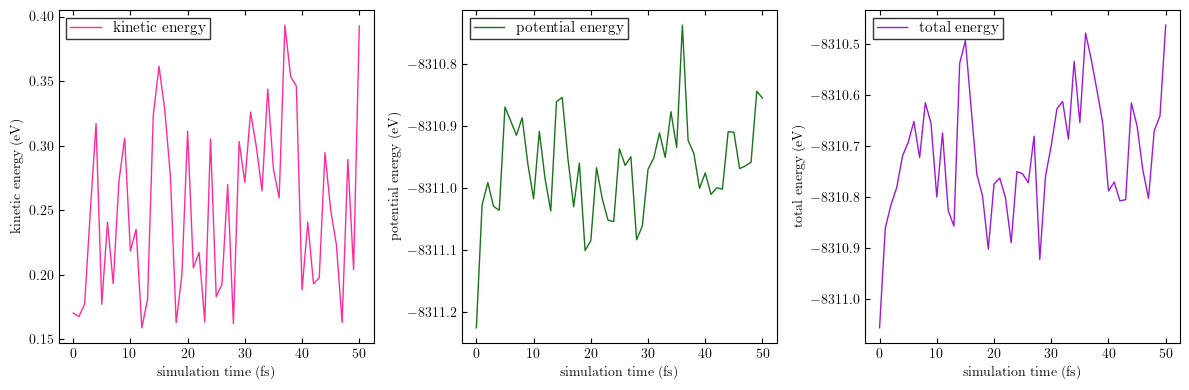

In [13]:
# plot import section
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('lines', lw=1, color='b')
rc('legend', loc='best')
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.fontsize'] = 11
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})


# PLOTS
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]

# kin
ax1.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax1.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax1.plot(kinetic_energies, label=r'$\textnormal{kinetic energy}$', color='deeppink', alpha=0.9)
ax1.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{kinetic energy}\;(\textnormal{eV})$')
ax1.legend(loc='best')

# pot
ax2.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax2.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax2.plot(potential_energies, label=r'$\textnormal{potential energy}$', color='darkgreen', alpha=0.9)
ax2.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{potential energy}\;(\textnormal{eV})$')
ax2.legend(loc='best')

# total
ax3.tick_params(bottom=True, top=True, left=True, right=False,
                    direction="in")
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                    labelright=False, direction="in")
ax3.plot(total_energies, label=r'$\textnormal{total energy}$', color='darkviolet', alpha=0.9)
ax3.set(xlabel=r'$\textnormal{simulation time}\;(\textnormal{fs})$', ylabel=r'$\textnormal{total energy}\;(\textnormal{eV})$')
ax3.legend(loc='best')

plt.tight_layout()
plt.savefig('./diamond_MD_plots.png', dpi=300)
plt.show(fig)

### __H2 diatomic potential__
Here we compute the PES of a diatomic molecule, H2 with the ANI-1ccx NNP.  

In [6]:
# general imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)
rc('lines', lw=1, color='b')
rc('legend', loc='best')
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.fontsize'] = 11
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})

from ase import Atoms
from ase.visualize import view

In [7]:
def evaluate_diatomics(atom_str, calculator_list, search_space=None , resolution=None, verbose=True):
    '''
    Definition
    ----------
    Evaluates the PES of simple (homoatomic) diatomic molecules A_2. 

    '''

    if resolution is None:
        resolution = 100

    if search_space is None:
        search_space = [0.3, 6.5]
    dist_list = np.linspace(search_space[0], search_space[1], resolution)

    print(f'computing {atom_str}2 PES\tscan range {search_space} Å')

    # save energies
    energies = []

    # evaluate each calculator
    for calc_ in calculator_list: 

        calc_energy_list = []

        for d in dist_list:

            # define the configuration
            atoms = Atoms(atom_str + '2', [[0, 0, 0], [0, 0, d]])
            atoms.calc = calc_
            E_pot = atoms.get_potential_energy()
            calc_energy_list.append(E_pot)
        
        atom = Atoms(atom_str)
        atom.calc = calc_
        atom_dissociated = 2 * atom.get_potential_energy()
        corrected_energies = np.array(calc_energy_list) - atom_dissociated

        energies.append(corrected_energies)

    return dist_list, energies


def plot_diatomics(atom_str_list, calculator_names, global_energies, global_distances, workdir='./'):
    '''
    Plot the different PES obtained via `evaluate_diatomics`. 
    '''

    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(12,4))
    ax_list = axes[0], axes[1], axes[2], axes[3]
    #ax_list = [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]

    for i in range(len(atom_str_list)):
        ax_list[i].tick_params(bottom=True, top=True, left=True, right=False, direction="in")
        ax_list[i].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")

        for k in range(len(calculator_names)):
            #label=r'$\textnormal{' + calculator_names[k] + r'}$'
            ax_list[i].plot(global_distances[i], global_energies[i][k][:], label=calculator_names[k], color=calculator_colors[k], alpha=0.9)

        #xlabel=r'$\textnormal{bond distance}\;\textnormal{(Å)}$', ylabel=r'$\textnormal{potential energy}\;\textnormal{(eV)}$'
        ax_list[i].set(xlabel=f'{atom_str_list[i]}-{atom_str_list[i]} bond distance (Å)', ylabel='potential energy (eV)')
        ax_list[i].legend(loc='best')

    plt.tight_layout()
    plt.savefig(os.path.join(workdir, 'diatomics_PES.png'), dpi=300)
    plt.show(fig)

/Users/sergiortizropero/miniconda3/envs/ASE_ANI/lib/python3.10/site-packages/torchani/resources/
/Users/sergiortizropero/miniconda3/envs/ASE_ANI/lib/python3.10/site-packages/torchani/resources/
computing H2 PES	scan range [0.3, 6.5] Å
computing C2 PES	scan range [0.7, 6.5] Å
computing N2 PES	scan range [0.7, 6.5] Å
computing O2 PES	scan range [0.9, 6.5] Å


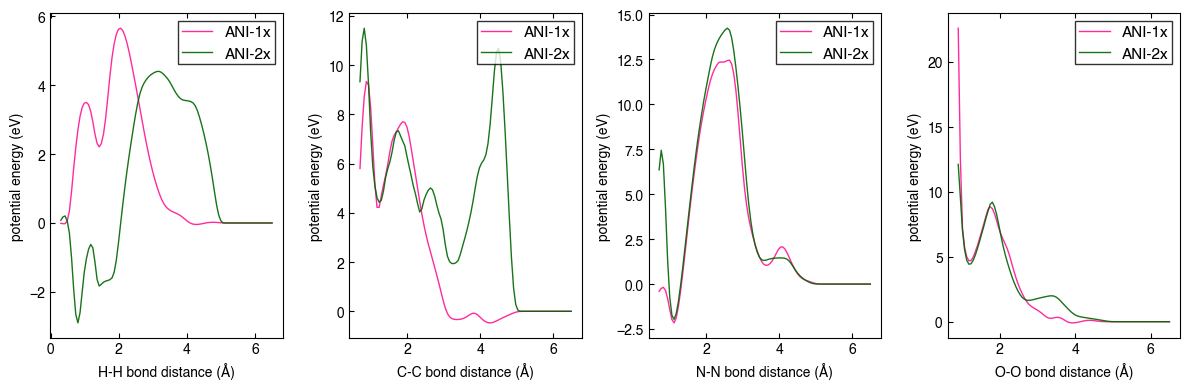

In [8]:
# calculator 
from torchani.models import ANI1x, ANI2x

ani1x_calc = ANI1x().ase()
ani2x_calc = ANI2x().ase()

# define the calculators
calculator_list = [ani1x_calc, ani2x_calc]
calculator_names = ['ANI-1x', 'ANI-2x']
calculator_colors = ['deeppink', 'darkgreen']


# define the diatomics and the PES scan range
atom_str_list = ['H', 'C', 'N', 'O']
search_list = [[0.3, 6.5], [0.7, 6.5], [0.7, 6.5], [0.9, 6.5]]
workdir = './'

# dimension: [atom_len, calc_len, resolution]
global_energies = []

# dimension: [atom_len, resolution]
global_distances = []

# compute all the PES
for i in range(len(atom_str_list)):
    dist_list, energies = evaluate_diatomics(atom_str_list[i], calculator_list, search_space=search_list[i])
    global_energies.append(energies)
    global_distances.append(dist_list)

plot_diatomics(atom_str_list, calculator_names, global_energies, global_distances, workdir=workdir)

## __2. Training TorchANI models [NO FARÀ FALTA]__

.

.

.

.

.

.

.

.

.



TODO

EXTRACT OF MACE:

While training models is not the ultimate goal, several examples on how to train and evaluate a MACE model with different datasets can be found [in the documentation](https://mace-docs.readthedocs.io/en/latest/examples/training_examples.html). Additional [tutorials](https://mace-docs.readthedocs.io/en/latest/examples/tutorials.html) are available, such as a [collab notebook](https://colab.research.google.com/drive/1ZrTuTvavXiCxTFyjBV4GqlARxgFwYAtX) for training and evaluating a model, and other tutorials for fine-tuning a pretrained model and MACE model theory. 


MACE offers the possibility to train a model within the MACE architecture given some training data. Extensive tutorials on how to train the model can be found [here](https://mace-docs.readthedocs.io/en/latest/examples/tutorials.html). A basic [introductory tutorial](https://colab.research.google.com/drive/1ZrTuTvavXiCxTFyjBV4GqlARxgFwYAtX) is provided.  

**Simple run.** A simple training and MD run was performed in [this]() Collab Notebook, which corresponds to the [ASE calculator](https://mace-docs.readthedocs.io/en/latest/guide/ase.html) section of the documentation. 